# Imports and constants. Testing Emils asdfadsf

## Mount Google Drive and start ngrok

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install tensorboardcolab

In [0]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import PIL
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')
from tensorboardcolab import TensorBoardColab
%matplotlib inline

# Взводим руками рандом сид для воспроизводимости обучения
manualSeed = 333
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
tbc=TensorBoardColab(graph_path='./My\ Drive/Colab\ Notebooks/Graph')
#tbc=TensorBoardColab()

Random Seed:  333
Wait for 8 seconds...
TensorBoard link:
http://c14f5440.ngrok.io


!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
pip install tensorboardX

In [0]:
# Директория с датасетом покемонов. Внимание!!! Чтобы даталоадер работал, необходимо положить картинки в 
# папку по типу .../pokemon/1/0.png, .../pokemon/1/1.png и т.д. Без этого даталоадер работать не будет
dataroot = "gdrive/My Drive/Colab Notebooks/dz/pokemon"

# Количество воркеров для даталоадера
workers = 8

# Размер батча для обучения
batch_size = 64

# Размер скрытого вектора z
nz = 100

# Кол-во эпох обучения
num_epochs = 50

# Размер картинки
image_size = 64

# Количество фильтров в генераторе и дискриминаторе
ngf = 32
ndf = 32 # дискриминировать легче, поэтому он легче

# Check dataloader outputs

-128 127
all data loaded. dataset len = 819


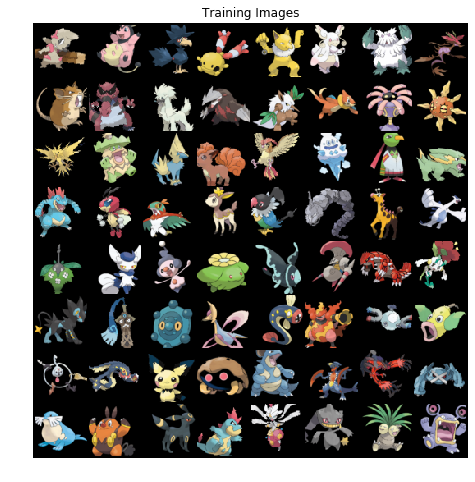

In [0]:
# разные аугментации 
basic_transform = transforms.Compose([
                    transforms.ToPILImage('RGB'),
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #изначально дата [0,1]
                   ])

complex_transform = transforms.Compose([
                      transforms.ToPILImage('RGB'),
                      transforms.Resize(image_size),
                      #transforms.CenterCrop(image_size),
                      transforms.Pad((image_size//10,image_size//10)),
                      transforms.RandomApply([transforms.RandomRotation(10)],p=0.5),
                      transforms.RandomCrop(image_size),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #изначально дата [0,1]
                    ])


# загружаем все картинки в память. их достаточно мало и это должно сильно ускорить процесс в Google Colab

class PokemonDataset(Dataset):
  
  def __init__(self, root_dir, transforms):
    
    super(PokemonDataset, self).__init__()
    """root_dir: папка с картинками"""
    files = os.listdir(root_dir)
    self.len = len(files)
    all_images = np.zeros((self.len,256,256,3))
    for i in range(len(files)):
        all_images[i] = plt.imread(os.path.join(root_dir, files[i]),format='RGB')[:,:,:3]
    all_images = all_images.astype(np.int8)
    print(all_images.min(), all_images.max())
    
    self.data = all_images
    self.transforms = transforms
    
    print("all data loaded. dataset len = {}".format(self.len))
    
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, idx):
    return self.transforms(self.data[idx])
      

pok_dtst = PokemonDataset(dataroot, complex_transform)

#создаем даталоадер
dataloader = torch.utils.data.DataLoader(pok_dtst, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)




# переключаемся на куду
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Выведем трейнсет, дабы убедиться, что все завелось
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Define Generator, Discriminator and utility functions

In [0]:
# функция для инициализации весов из статьи про GAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Генератор

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

class Generator(nn.Module):
    def __init__(self, nz, ngf):
        """Args:
            nz: размерность латентного пространства
            ngf: ngf. влияет на размер модели """
        # тут ваш код генератора
        super(Generator, self).__init__()

        
        main = nn.Sequential(
            # better with fc
            nn.Linear(nz, ngf*8*4*4),
            View((batch_size,ngf*8,4,4)),
            #nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(), # 4*4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(), # 8*8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(), # 16*16
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(), # 32*3
        )
        one_more = nn.Sequential(
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(), # 64*64
        )
        final = nn.Sequential(
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=True), #128*128
            nn.Tanh()
        )
        if image_size == 128:
            self.main = nn.Sequential(main, one_more, final)
            
        elif image_size == 64:
            self.main = nn.Sequential(main, final)

    def forward(self, input):
        
        return self.main(input)
      
# Генератор2 Использует Upsample + Conv вместо ConvTranspose

class GeneratorUp(nn.Module):
    def __init__(self, nz, ngf):
        """Args:
            nz: размерность латентного пространства
            ngf: ngf. влияет на размер модели """
        # тут ваш код генератора
        super(GeneratorUp, self).__init__()
        main = nn.Sequential(
            # лучше используем Dense слой
            nn.Linear(nz, ngf*8*4*4),
            View((batch_size,ngf*8,4,4)),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(), # 4*4
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 8, ngf * 4, 3, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(), # 8*8
            #nn.Conv2d(ngf * 4, ngf * 4, 3, padding=1),
            #nn.BatchNorm2d(ngf * 4),
            #nn.LeakyReLU(), # 8*8
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 4, ngf * 2, 3, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(), # 16*16
            #nn.Conv2d(ngf * 2, ngf * 2, 3, padding=1),
            #nn.BatchNorm2d(ngf * 2),
            #nn.LeakyReLU(), # 16*16
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 2, ngf , 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 32*32
            #nn.Conv2d(ngf, ngf, 3, padding=1),
            #nn.BatchNorm2d(ngf),
            #nn.LeakyReLU(), # 32*32
            
        )
        one_more = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 64*64
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 64*64
            
        )
        final = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ngf, 3, 3, padding=1),
            nn.BatchNorm2d(3),
            #nn.LeakyReLU(), # 64*64 или 128*128
            #nn.Conv2d(ngf, 3, 3, padding=1),
            #nn.BatchNorm2d(3), #64*64 или 128*128
            
            nn.Tanh()
        )
        if image_size == 128:
            self.main = nn.Sequential(main, one_more, final)
            
        elif image_size == 64:
            self.main = nn.Sequential(main, final)

    def forward(self, input):
        
        return self.main(input)
      
class GeneratorUp2(nn.Module):
    def __init__(self, nz, ngf):
        """Args:
            nz: размерность латентного пространства
            ngf: ngf. влияет на размер модели """
        # тут ваш код генератора
        super(GeneratorUp2, self).__init__()
        main = nn.Sequential(
            # лучше используем Dense слой
            nn.Linear(nz, ngf*8*4*4),
            View((batch_size,ngf*8,4,4)),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(), # 4*4
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 8, ngf * 4, 3, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(), # 8*8
            nn.Conv2d(ngf * 4, ngf * 4, 3, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(), # 8*8
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 4, ngf * 2, 3, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(), # 16*16
            nn.Conv2d(ngf * 2, ngf * 2, 3, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(), # 16*16
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf * 2, ngf , 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 32*32
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 32*32
            
        )
        one_more = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 64*64
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 64*64
            
        )
        final = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ngf, ngf, 3, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(), # 64*64 или 128*128
            nn.Conv2d(ngf, 3, 3, padding=1),
            nn.BatchNorm2d(3), #64*64 или 128*128
            
            nn.Tanh()
        )
        if image_size == 128:
            self.main = nn.Sequential(main, one_more, final)
            
        elif image_size == 64:
            self.main = nn.Sequential(main, final)

    def forward(self, input):
        
        return self.main(input)

In [0]:
# Создали генератор
netG = Generator(nz, ngf).to(device)

# Инициализировали его
netG.apply(weights_init)

# Вывели модель для отладки
print(netG)

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=4096, bias=True)
      (1): View()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


In [0]:
# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self, ndf):
        # тут ваш код генератора
        super(Discriminator, self).__init__()
        main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False), # 64x64 => 32x32
            nn.LeakyReLU(0.1, inplace=True),
            
            #nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=True),
            #nn.BatchNorm2d(ndf * 2),
            #nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(ndf , ndf * 2, 4, 2, 1, bias=True), # 32x32 => 16x16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),
            
            #nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=True),
            #nn.BatchNorm2d(ndf * 4),
            #nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True), #16x16 => 8x8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),
            
            #nn.Conv2d(ndf * 4, ndf * 8, 3, 1, 1, bias=True),
            #nn.BatchNorm2d(ndf * 8),
            #nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=True), #8x8 => 4x4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.1, inplace=True),
            
        )
        one_more = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=True), #8*8 => 4*4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.1, inplace=True)
        )
        final = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False), # 4*4 => 1*1*1
            nn.Sigmoid()
        )
        
        if image_size == 128:
            self.main = nn.Sequential(main, one_more, final)
            
        elif image_size == 64:
            self.main = nn.Sequential(main, final)
        

    def forward(self, input):
        return torch.squeeze(self.main(input))
      


In [0]:
# Создали дискриминатор
netD = Discriminator(ndf).to(device)

# Ининциализировали весе
netD.apply(weights_init)

# Вывели модель для отладки
print(netD)

Discriminator(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.1, inplace)
      (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.1, inplace)
      (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): Sigmoid()
    )
  )
)


# Define train functions

In [0]:
# Фиксированный шум для мониторинга качества генерации
fixed_noise = torch.randn(64, nz, device=device) # removed 1,1 for FC

# Коэффициент обучения
lr = 0.0002

# Оптимизаторы для сеток
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

In [0]:
# код для обучения дискриминатора
def train_D(discriminator, images, fake_images, soft=True, noise=True):
    """soft: makes label for real in [0.9,1] and for false in [0,0.1]
       noise: makes 5% of labels noisy"""
    discriminator.zero_grad()
    
    # train on real images
    real_label = 1. - np.random.rand()/10 if soft else 1. # making soft true labels
    fake_label = np.random.rand()/10 if soft else 0.      # make soft false labels
    label = torch.full((batch_size,), real_label, device=device)
    if noise:
      idx = torch.randint(0,batch_size,(batch_size//20,))
      label[idx] = fake_label
    real_score = discriminator(images)
    lossD_R = nn.BCELoss()(real_score, label)
    lossD_R.backward()
    
    # train on fake
 
    label.fill_(fake_label)
    if noise:
      idx = torch.randint(0,batch_size,(batch_size//10,))
      label[idx] = real_label
    fake_score = discriminator(fake_images.detach())
    lossD_F = nn.BCELoss()(fake_score, label)
    lossD_F.backward()
    
    loss_D = lossD_R + lossD_F
    optimizerD.step()
    return loss_D, real_score, fake_score

In [0]:
# код для обучения генератора
def train_G(generator, discriminator, fake_images):
    generator.zero_grad()
    label = torch.full((batch_size,), 1, device=device) # 1 is real label
    output = discriminator(fake_images)
    loss_G = nn.BCELoss()(output, label)
    loss_G.backward(retain_graph=True,)
    optimizerG.step()
    return loss_G

In [0]:
def init_cache(noise, stack = 4):
  """Returns tensor of shape (64*2**stack,3,image_size,image_size)"""
  cache = netG(noise).detach().cpu()
  for i in range(stack):
    cache = torch.cat([cache,cache])
  print("Cache size: {} images".format(cache.shape[0]))
  return cache

def update_cache():
  global cache_idx
  """Inserts new images in cache, takes random images from cache to images"""
  fraction = 0.1 # put fraction% of batch in cache and replace it with data taken from cache
  cache_size = cache.shape[0]
  # update cache
  num_upd = int(fraction * batch_size)
  idx_1 = torch.randint(0,batch_size,(num_upd,)) #idx to put in cache
  imgs = fake_images[idx_1].cpu()
  if cache_idx+num_upd > cache_size:
    cache[cache_idx:cache_idx+num_upd] = imgs[:cach_size - cache_idx]
    cache[0:cache_idx+num_upd - cache_size] = imgs[cach_size - cache_idx:]
  else:
    cache[cache_idx:cache_idx+num_upd] = imgs
  cache_idx = (cache_idx + num_upd) % cache_size
  
  #insert images from cahce
  idx_2 = torch.randint(0,cache_size,(num_upd,)) #idx to get from cache
  imgs = cache[idx_2].to(device)
  fake_images[idx_1] = imgs
  
  
  

#cache = init_cache(fixed_noise).cpu() #init cache

# Train

In [0]:
!rm -rf ./My\ Drive/Colab\ Notebooks/Graph/*

In [0]:
# Training Loop

num_epochs = 10000
cache_idx = 0

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
skip_D_step = False
skip_G_step = False

d_episodes = 1
postfix = {'loss_d' : 0, 'loss_g' : 0, 'score_real' :0, 'score_fake' :0}


print("Starting Training Loop...")

# чтобы генератор и дискриминатор не ходили по кругу, будем хранить кеш из старых картинок и случайно подсовывать их вместе с новыми


with tqdm_notebook(total=num_epochs,unit='epoch',postfix = postfix) as t:
  for epoch in range(num_epochs):
    
    #t.set_postfix(postfix)
    #for i, data in 
    #for i, data in tqdm_notebook(enumerate(dataloader),total=len(dataloader), 
    #                             leave=False, unit='batch', postfix = postfix):

    t.set_postfix(postfix)
    t.update()
    for i, data in enumerate(dataloader):
       
        # обучаем дискриминатор
        # d_loss = wasserstein loss дискриминатора
        # real_score - оценки дискриминатора для настоящих картинок
        # fake_score - оценки дискриминатора для фейковых картинок
        # помните, что на одну итерацию обучения генератора
        # должно приходиться несколько итераций обучения дискриминатора!
        real_data = data.to(device)
        
        noise = torch.randn((batch_size, nz), device=device)
        fake_images = netG(noise)
        #fake_images = fake_images_g.clone()
    
        #update_cache() #update fake_images not working (())
        
        fake_images = fake_images.to(device)
        
        if not skip_D_step:
            d_loss, real_score, fake_score = train_D(netD, real_data, fake_images)
            d_loss, real_score, fake_score = train_D(netD, real_data, fake_images)
        
        # обучаем генератор
        # g_loss = critic-loss генератора
        if not skip_G_step:
            g_loss = train_G(netG, netD, fake_images)
            #if d_loss < g_loss: #пытаемся не допустить большого разрыва
            g_loss = train_G(netG, netD, fake_images) #потому что генератор жирнее
        
        # Выводим стату
        #if i % 1 == 0:
            #msg = '[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}'.format(
            #    epoch, num_epochs, i, len(dataloader), 
            #    d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item())
            #tqdm.write(msg)
        #    print('[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}'.format(
        #        epoch, num_epochs, i, len(dataloader), 
        #        d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
        
        # log running average. with alpha 0.8 it will forget everything in 2-3 epochs
        alpha=0.8
        postfix['loss_d'] = postfix['loss_d']*alpha + d_loss.item()*(1-alpha)
        postfix['loss_g'] = postfix['loss_g']*alpha + g_loss.item()*(1-alpha)
        postfix['score_real'] = postfix['score_real']*alpha + real_score.mean().item()*(1-alpha)
        postfix['score_fake'] = postfix['score_fake']*alpha + fake_score.mean().item()*(1-alpha)
        
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        thr = 15
        skip_D_step = True if (g_loss.item() / d_loss.item()) > thr else False
        skip_G_step = True if (d_loss.item() / g_loss.item()) > thr else False
        

        # Сохраняем результат генерации для нашего фиксированного шума( для валидации )
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img = vutils.make_grid(fake, padding=2, normalize=True)
            img = np.expand_dims(np.transpose(img, (1,2,0)),axis=0)                              
            tbc.save_image("Img_ep_{}".format(epoch), img)
            
            #img_list.append(img)            

            msg = '[{}/{}] \tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}'.format(
                epoch, num_epochs,
                d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item())
            #tqdm.write(msg)
            
        if (iters % 500 == 0):
          tbc.save_value("Loss", "D Loss", epoch, d_loss.item())
          tbc.save_value("Loss", "G Loss", epoch, g_loss.item())
          tbc.save_value("Score", "Real Score", epoch, real_score.mean().item())
          tbc.save_value("Score", "Fake Score", epoch, fake_score.mean().item())
        # Контролируем что они друг друга не сильно обгоняют


        iters += 1
        

Starting Training Loop...


# Visualize the results

In [0]:
# Выводим на печать всяческие loss'ы
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::10],label="G")
plt.plot(D_losses[::10],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

In [0]:
# Проигрываем результаты генерации для фиксированного шума
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::2]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Сравниваем настоящие данные и генерацию
real_batch = next(iter(dataloader))

# Рисуем трейнсет
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Рисуем фейки
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()